In [2]:
#Final Year Project 
#Sentiment Analysis
#Amazon Product Reviews
#Women's E-Commerce Clothing Reviews

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import time
# NLP
import nltk
import re
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS

from textblob import TextBlob


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\parul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


READ DATA

In [4]:
df = pd.read_csv(r'C:\Users\parul\OneDrive\Desktop\TCD\Final Year project\Womens Clothing E-Commerce Reviews.csv')
df.head(10)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
5,5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses
6,6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits
7,7,858,39,"Shimmer, surprisingly goes with lots","I ordered this in carbon for store pick up, an...",4,1,4,General Petite,Tops,Knits
8,8,1077,24,Flattering,I love this dress. i usually get an xs but it ...,5,1,0,General,Dresses,Dresses
9,9,1077,34,Such a fun dress!,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5,1,0,General,Dresses,Dresses


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [6]:
df.describe()

,Unnamed: 0,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000
mean,11742.500000,918.118709,43.198544,4.196032,0.822362,2.535936
std,6779.968547,203.298980,12.279544,1.110031,0.382216,5.702202
min,0.000000,0.000000,18.000000,1.000000,0.000000,0.000000
25%,5871.250000,861.000000,34.000000,4.000000,1.000000,0.000000
50%,11742.500000,936.000000,41.000000,5.000000,1.000000,1.000000
75%,17613.750000,1078.000000,52.000000,5.000000,1.000000,3.000000
max,23485.000000,1205.000000,99.000000,5.000000,1.000000,122.000000


FIX THE DATAFRAME FOR EASIER ACCESS

In [7]:
df.columns = ["_".join(name.lower().strip().split()) for name in df.columns]

In [8]:
df.head()

,unnamed:_0,clothing_id,age,title,review_text,rating,recommended_ind,positive_feedback_count,division_name,department_name,class_name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [9]:
# Drop the Unnamed column
df.drop(["unnamed:_0"],axis = 1, inplace= True)

CONVERT RATING TO SENTIMENT SCORE
1,2 ==> -1
3 ==> 0
4,5 ==> 1

In [10]:
def to_sentiment(star_rating):
    if star_rating in {1, 2}: # negative
        return -1 
    if star_rating == 3:      # neutral
        return 0
    if star_rating in {4, 5}: # positive
        return 1
    
# convert star rating into sentiment
df['sentiment'] = df['rating'].apply(lambda star_rating: to_sentiment(star_rating=star_rating))
df.drop("rating",axis = 1,inplace = True)

EXPLORATORY DATA ANALYSIS

In [11]:
df.isnull().sum()

clothing_id                   0
age                           0
title                      3810
review_text                 845
recommended_ind               0
positive_feedback_count       0
division_name                14
department_name              14
class_name                   14
sentiment                     0
dtype: int64

Let's seperate model features and target

In [12]:
model_target = "sentiment"
model_features = df.columns.drop("sentiment")

print("Model Target: ",model_target)
print("Model Features: ",model_features)

Model Target:  sentiment
Model Features:  Index(['clothing_id', 'age', 'title', 'review_text', 'recommended_ind',
       'positive_feedback_count', 'division_name', 'department_name',
       'class_name'],
      dtype='object')


We can explore the features set further, figuring out first what features are numerical or categorical.

In [13]:
numerical_features_all = df[model_features].select_dtypes(include=np.number).columns
print('Numerical columns:',numerical_features_all)

print('')

categorical_features_all = df[model_features].select_dtypes(include='object').columns
print('Categorical columns:',categorical_features_all)

Numerical columns: Index(['clothing_id', 'age', 'recommended_ind', 'positive_feedback_count'], dtype='object')

Categorical columns: Index(['title', 'review_text', 'division_name', 'department_name',
       'class_name'],
      dtype='object')


TARGET DISTRIBUTION

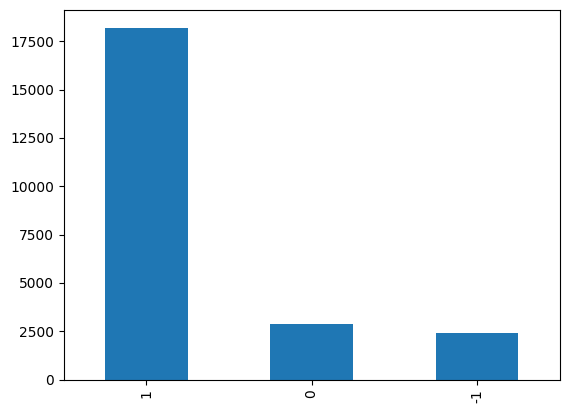

In [14]:
df[model_target].value_counts().plot.bar()
plt.show()

In [15]:
df[model_target].value_counts(normalize=True)

 1    0.775270
 0    0.122243
-1    0.102487
Name: sentiment, dtype: float64

UNIVARIATE STATISTICS: BASIC PLOTS

Categorical Variables

In [16]:
for c in categorical_features_all: 
    print(df[c].value_counts())

Love it!                                   136
Beautiful                                   95
Love                                        88
Love!                                       84
Beautiful!                                  72
                                          ... 
Perfect transition dress                     1
The perfect spring dress!                    1
Super soft but can make you look frumpy      1
More structured than a cardi                 1
Please make more like this one!              1
Name: title, Length: 13993, dtype: int64
Perfect fit and i've gotten so many compliments. i buy all my suits from here now!                                                                                                                                                                                                                                                                                                                                                                        

division_name


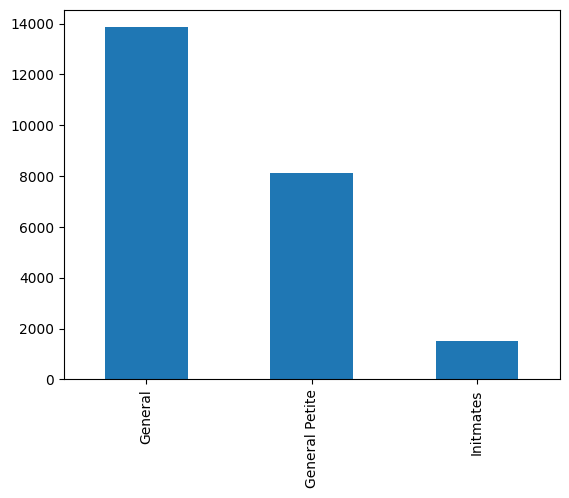

department_name


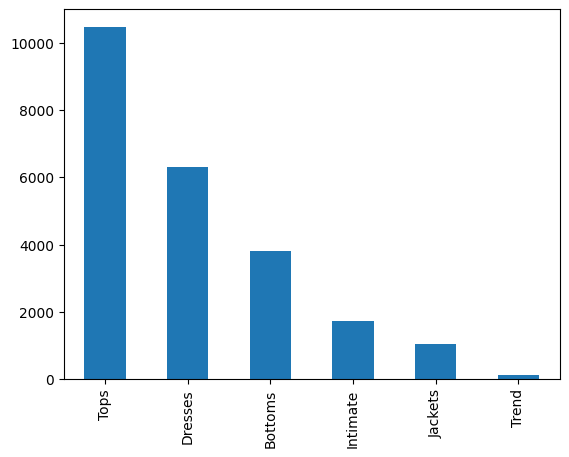

class_name


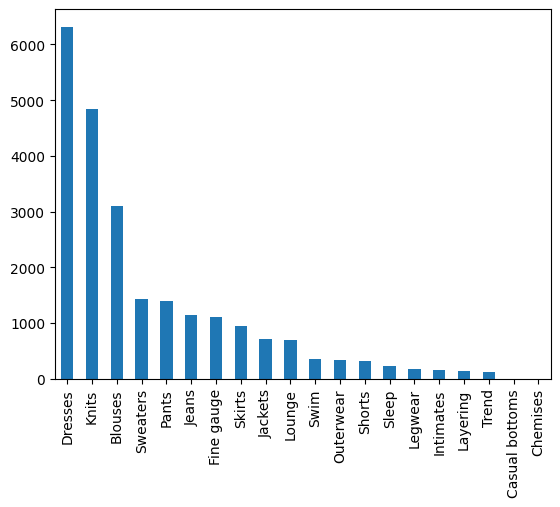

In [17]:
for c in categorical_features_all:
    if len(df[c].value_counts()) < 50:
        print(c)
        df[c].value_counts().plot.bar()
        plt.show()

Numerical Variables

In [18]:
for c in numerical_features_all:
    print("\n",c)
    print(df[c].value_counts(bins = 20))


 clothing_id
(843.5, 903.75]      5897
(1024.25, 1084.5]    5310
(1084.5, 1144.75]    3522
(783.25, 843.5]      2723
(903.75, 964.0]      1997
(964.0, 1024.25]     1757
(241.0, 301.25]       255
(120.5, 180.75]       240
(361.5, 421.75]       211
(602.5, 662.75]       185
(1144.75, 1205.0]     178
(662.75, 723.0]       162
(482.0, 542.25]       159
(180.75, 241.0]       157
(421.75, 482.0]       153
(542.25, 602.5]       134
(301.25, 361.5]       134
(723.0, 783.25]       117
(60.25, 120.5]        102
(-1.206, 60.25]        93
Name: clothing_id, dtype: int64

 age
(34.2, 38.25]      3297
(38.25, 42.3]      3278
(30.15, 34.2]      2729
(42.3, 46.35]      2438
(46.35, 50.4]      2078
(50.4, 54.45]      1790
(26.1, 30.15]      1692
(54.45, 58.5]      1439
(22.05, 26.1]      1246
(58.5, 62.55]      1227
(62.55, 66.6]       988
(66.6, 70.65]       504
(17.918, 22.05]     400
(70.65, 74.7]       187
(74.7, 78.75]        69
(82.8, 86.85]        57
(78.75, 82.8]        43
(86.85, 90.9]       

clothing_id


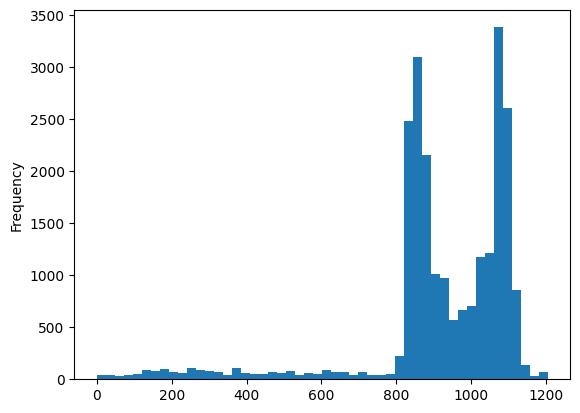

age


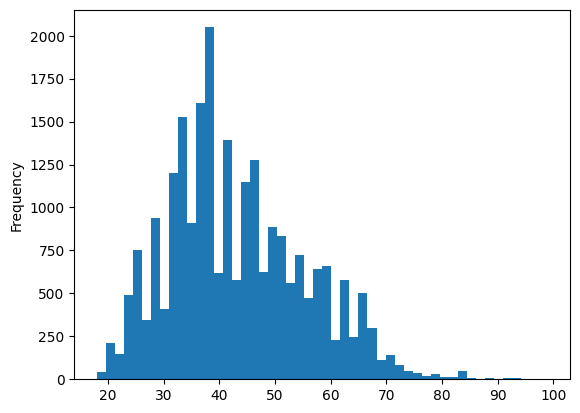

recommended_ind


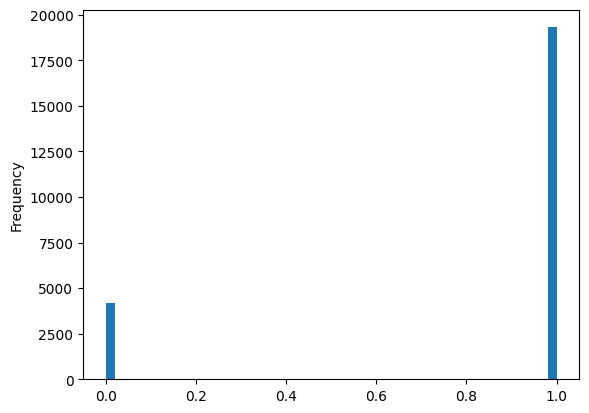

positive_feedback_count


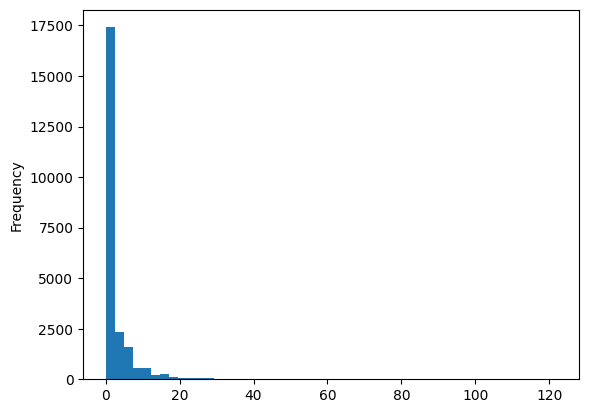

In [19]:
for c in numerical_features_all:
    print(c)
    df[c].plot.hist(bins=50)
    plt.show()

Pairplot

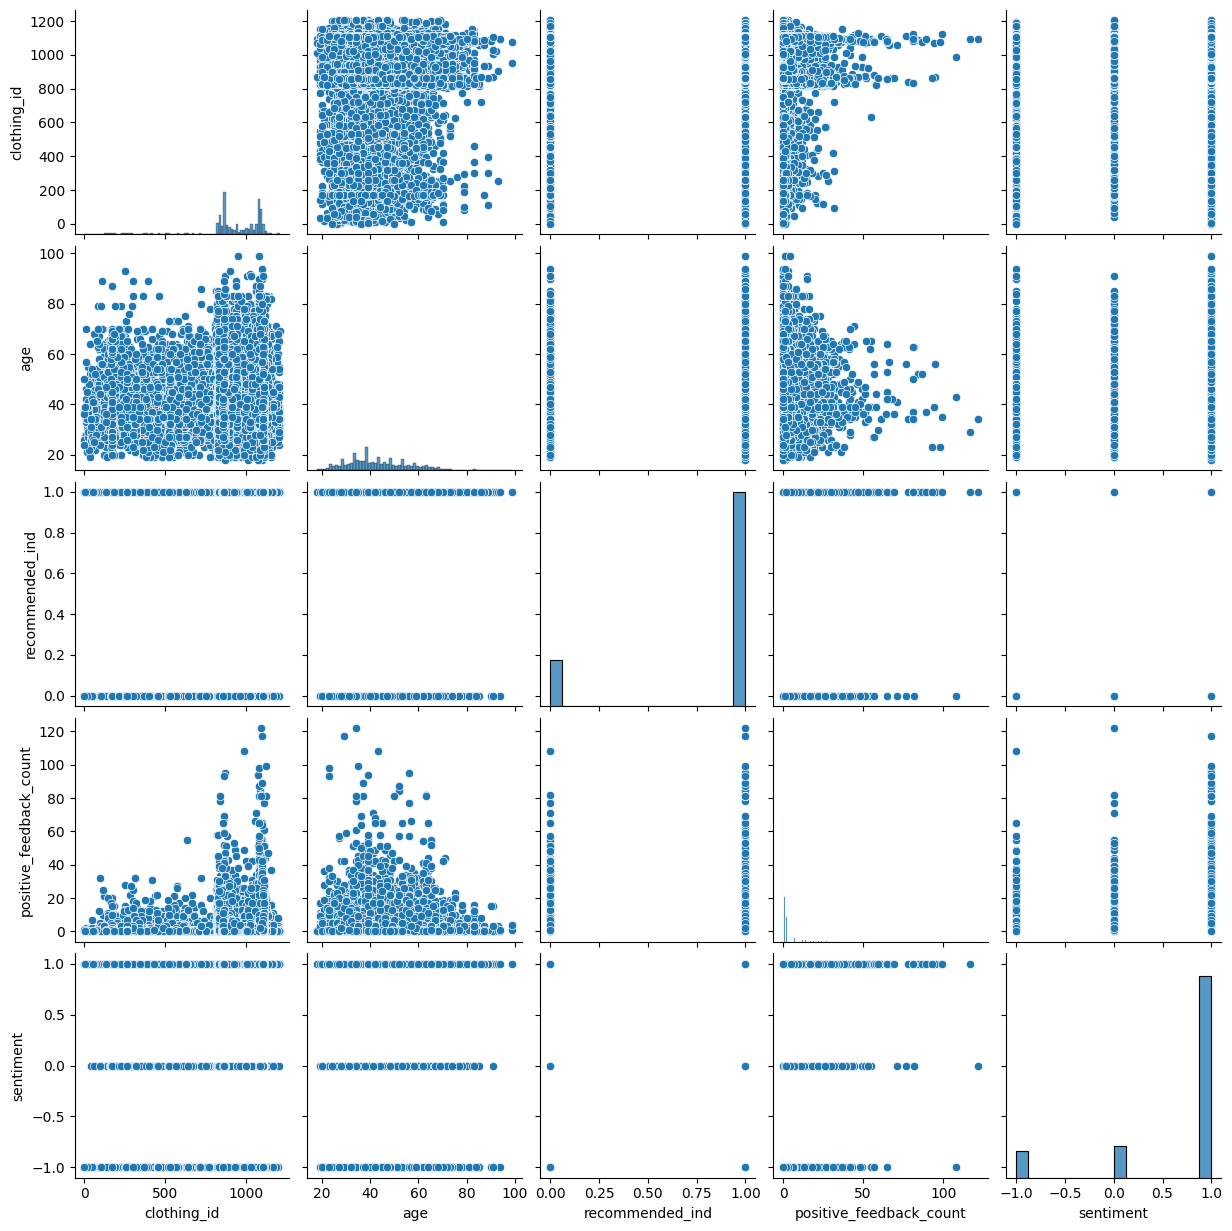

In [20]:
sns.pairplot(df)
plt.show()

HEATMAP

C:\Users\parul\AppData\Local\Temp\ipykernel_21544\184024840.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

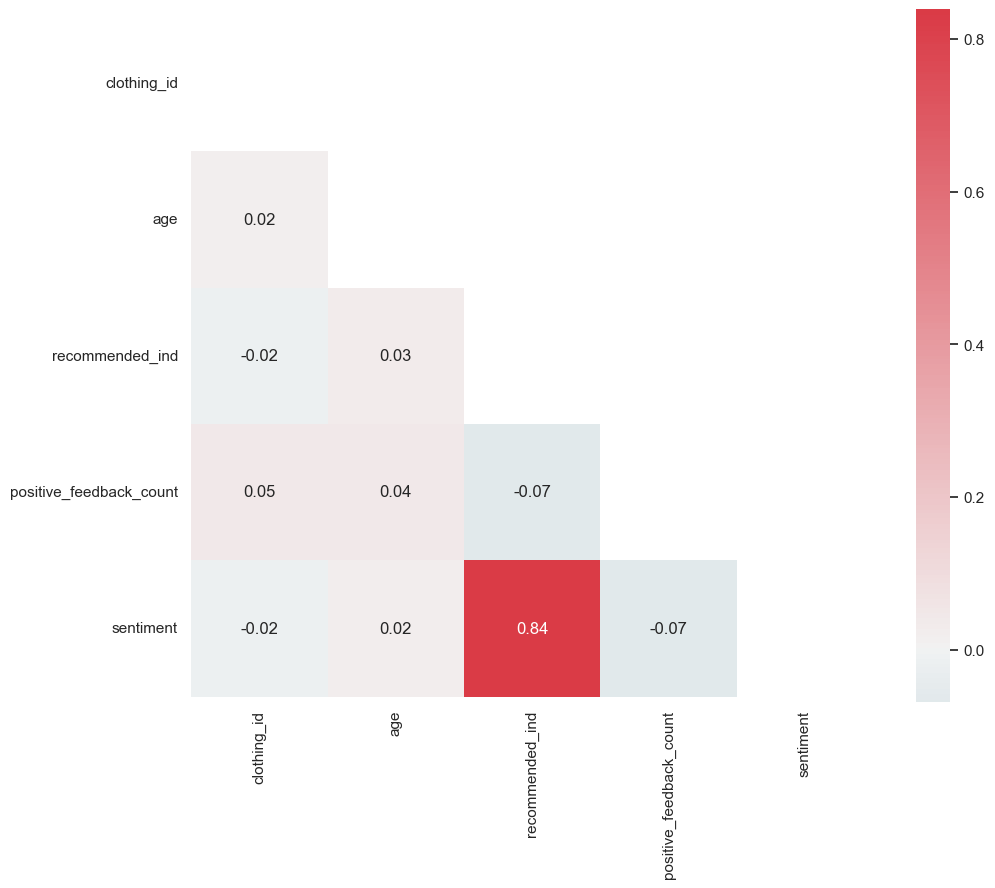

In [21]:
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool_))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,annot = True,fmt= ".2f",
            square=True)

SELECT FEATURES

In [22]:
final_df = df[["review_text","sentiment"]]
final_df.dropna(inplace = True)

final_df.isnull().sum()

C:\Users\parul\AppData\Local\Temp\ipykernel_21544\2314882738.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.dropna(inplace = True)


review_text    0
sentiment      0
dtype: int64

Dropping Null Data

TEXT EDA

In [23]:
final_df.head()

,review_text,sentiment
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
2,I had such high hopes for this dress and reall...,0
3,"I love, love, love this jumpsuit. it's fun, fl...",1
4,This shirt is very flattering to all due to th...,1


In [24]:
final_df.review_text[1]

'Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.'

In [25]:
print(f"Dataset Shape: {final_df.shape}")

Dataset Shape: (22641, 2)


Check the duplicate data

In [26]:
final_df[final_df.duplicated()]

,review_text,sentiment
10067,Perfect fit and i've gotten so many compliment...,1
11074,"Lightweight, soft cotton top and shorts. i thi...",1
12526,I purchased this and another eva franco dress ...,-1
13354,Perfect fit and i've gotten so many compliment...,1
14275,I bought this shirt at the store and after goi...,1
21470,The sweater and skirt are so pretty! they're r...,1
21888,"Love, love these jeans. being short they come ...",1


There are 7 duplicate data. I will drop them

In [27]:
final_df.drop_duplicates(inplace = True)
final_df[final_df.duplicated()]

C:\Users\parul\AppData\Local\Temp\ipykernel_21544\105781564.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.drop_duplicates(inplace = True)


,review_text,sentiment


In [28]:
print(f"Dataset Shape: {final_df.shape}")

Dataset Shape: (22634, 2)


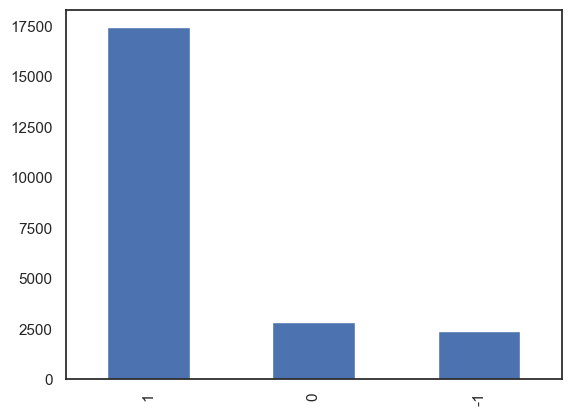

 1    17442
 0     2823
-1     2369
Name: sentiment, dtype: int64


In [29]:
# Target distribution

final_df.sentiment.value_counts().plot.bar()
plt.show()
print(final_df.sentiment.value_counts())


In [30]:
final_df['review_length'] = final_df['review_text'].apply(len)
print(final_df.shape)
final_df.head()

(22634, 3)


C:\Users\parul\AppData\Local\Temp\ipykernel_21544\97448937.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['review_length'] = final_df['review_text'].apply(len)


,review_text,sentiment,review_length
0,Absolutely wonderful - silky and sexy and comf...,1,53
1,Love this dress! it's sooo pretty. i happene...,1,303
2,I had such high hopes for this dress and reall...,0,500
3,"I love, love, love this jumpsuit. it's fun, fl...",1,124
4,This shirt is very flattering to all due to th...,1,192


In [31]:
final_df.describe().T

,count,mean,std,min,25%,50%,75%,max
sentiment,22634.0,0.665945,0.657124,-1.0,1.0,1.0,1.00,1.0
review_length,22634.0,308.698065,143.932380,9.0,186.0,301.0,458.75,508.0


In [32]:
for i in np.unique(final_df.sentiment):
    print(np.unique(final_df.sentiment)[i])
    print(final_df[final_df.sentiment == i].review_length.value_counts(bins = 30))

1
(491.733, 508.0]      475
(198.933, 215.2]      105
(231.467, 247.733]     95
(215.2, 231.467]       95
(150.133, 166.4]       88
(377.867, 394.133]     87
(182.667, 198.933]     85
(264.0, 280.267]       82
(166.4, 182.667]       81
(247.733, 264.0]       81
(312.8, 329.067]       80
(280.267, 296.533]     80
(345.333, 361.6]       77
(296.533, 312.8]       74
(394.133, 410.4]       73
(133.867, 150.133]     72
(361.6, 377.867]       71
(329.067, 345.333]     71
(117.6, 133.867]       65
(101.333, 117.6]       58
(410.4, 426.667]       57
(459.2, 475.467]       48
(68.8, 85.067]         46
(442.933, 459.2]       46
(475.467, 491.733]     45
(85.067, 101.333]      43
(426.667, 442.933]     38
(52.533, 68.8]         36
(36.267, 52.533]       12
(19.511, 36.267]        3
Name: review_length, dtype: int64
-1
(487.9, 504.0]    688
(326.9, 343.0]    120
(262.5, 278.6]    118
(198.1, 214.2]    112
(165.9, 182.0]     98
(343.0, 359.1]     98
(278.6, 294.7]     96
(214.2, 230.3]     96
(182.

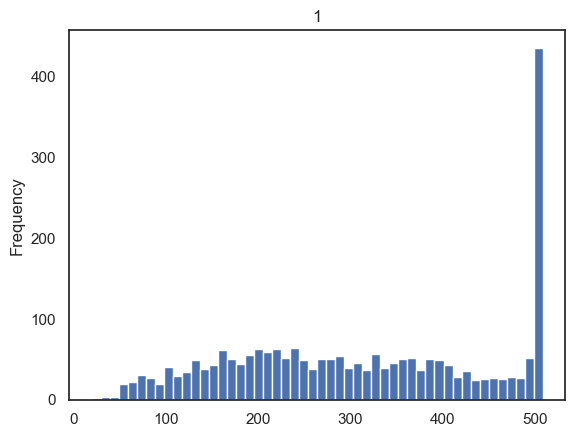

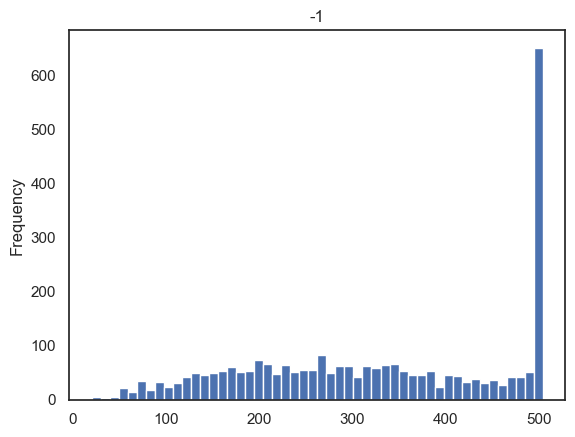

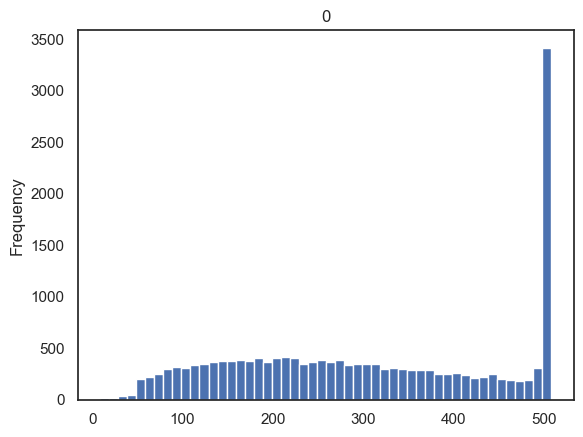

In [33]:
for i in np.unique(final_df.sentiment):
    final_df[final_df.sentiment == i].review_length.plot.hist(bins = 50)
    plt.title(np.unique(final_df.sentiment)[i])
    plt.show()

Text Polarity
The polarity score is a float within the range [-1.0, 1.0].

The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [34]:
## Text Polarity
final_df['polarity'] = final_df['review_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
final_df.head(5)

C:\Users\parul\AppData\Local\Temp\ipykernel_21544\1723556540.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['polarity'] = final_df['review_text'].apply(lambda x: TextBlob(x).sentiment.polarity)


,review_text,sentiment,review_length,polarity
0,Absolutely wonderful - silky and sexy and comf...,1,53,0.633333
1,Love this dress! it's sooo pretty. i happene...,1,303,0.339583
2,I had such high hopes for this dress and reall...,0,500,0.073675
3,"I love, love, love this jumpsuit. it's fun, fl...",1,124,0.550000
4,This shirt is very flattering to all due to th...,1,192,0.512891


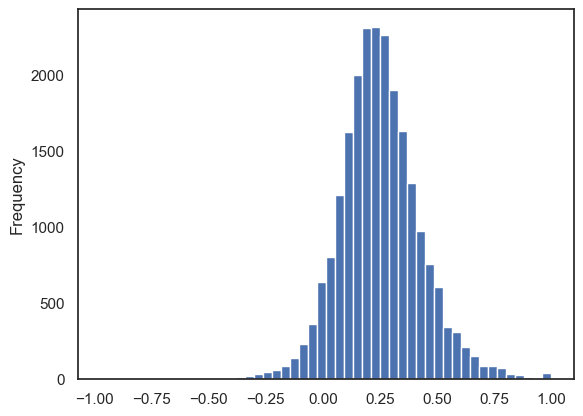

In [35]:
final_df.polarity.plot.hist(bins=50)
plt.show()

C:\Users\parul\AppData\Local\Temp\ipykernel_21544\2645429914.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(final_df.corr(),annot=True,fmt='.2g')


<Axes: >

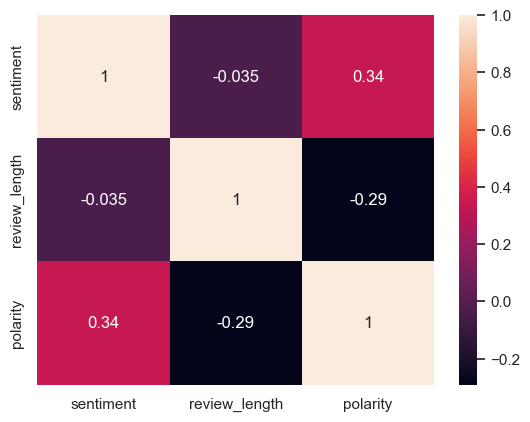

In [36]:
sns.heatmap(final_df.corr(),annot=True,fmt='.2g')

In [37]:
def CloudWord(column):
  comment_words = ''
  stopwords = set(STOPWORDS)
  
  # iterate through the csv file
  for val in df[column]:
      # typecaste each val to string
      val = str(val)
      # split the value
      tokens = val.split()
      # Converts each token into lowercase
      for i in range(len(tokens)):
          tokens[i] = tokens[i].lower()
      comment_words += " ".join(tokens)+" "
  wordcloud = WordCloud(width = 800, height = 800,
                  background_color ='black',
                  stopwords = stopwords,
                  min_font_size = 10).generate(comment_words)
  
  # plot the WordCloud image                      
  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.title(f"Most Common Words in The {column.upper()} column")
  plt.axis("off")
  plt.tight_layout(pad = 0)
  
  plt.show()

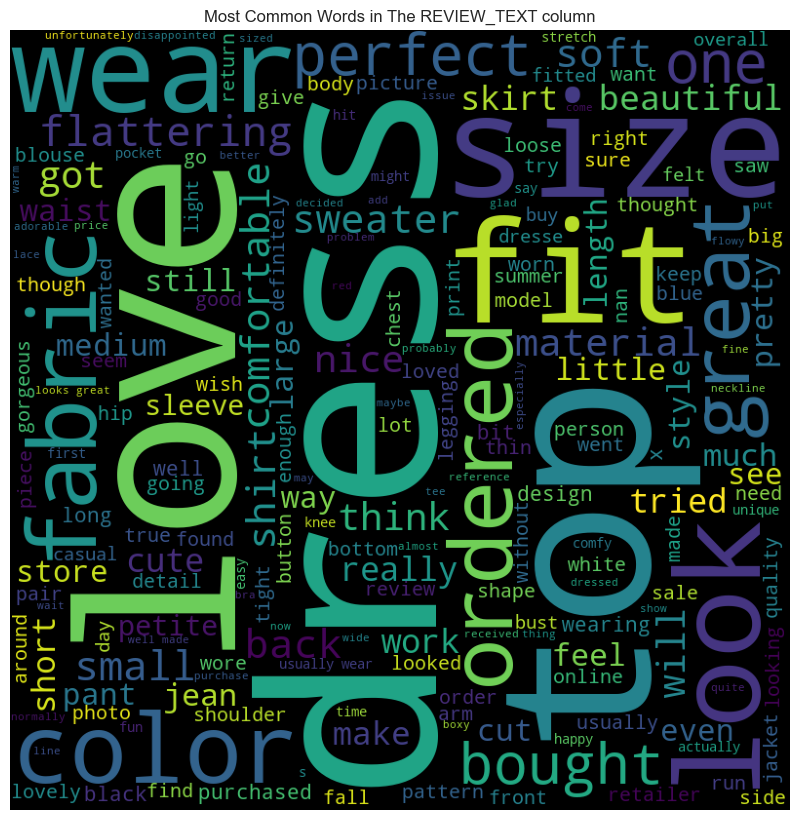

In [38]:
CloudWord("review_text")

Preprocessing - Text features

In [39]:
snow_stemmer = SnowballStemmer(language='english')
def preprocess_text(data):
    review = re.sub('[^a-zA-Z]', ' ', data)
    review = review.lower()
    review = review.split()
    
    review = [snow_stemmer.stem(word) for word in review if not word in stopwords.words('english')] # Remove the stopwords
    review = ' '.join(review)
    return review

In [40]:
X = final_df["review_text"]
y = final_df["sentiment"]

X = X.apply(preprocess_text)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state = 42 )

print('Datasets shapes: ', X_train.shape, X_test.shape)

Datasets shapes:  (15843,) (6791,)


In [41]:
X_train.head()

15516    great top easi wear look great jean dressier pant
17178    final saw dress onlin say look better person m...
5745     top made well strap holder keep bra hidden alw...
21759    bought top white usual size larg base review s...
7708     love cozi comfi top overs name say impli norma...
Name: review_text, dtype: object

Creating Bag of Words model

In [42]:
MAX_FEATURES = 3000
cv = CountVectorizer(max_features=MAX_FEATURES)
X_trainds = cv.fit_transform(X_train).toarray()
X_testds = cv.transform(X_test).toarray()

MODELS

In [43]:
# Models
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, roc_auc_score,balanced_accuracy_score, classification_report, confusion_matrix

DUMMY CLASSIFIER

Accuracy Score 0.7760270946841408
------------------------------------------------------------
Balanced Accuracy Score 0.3333333333333333


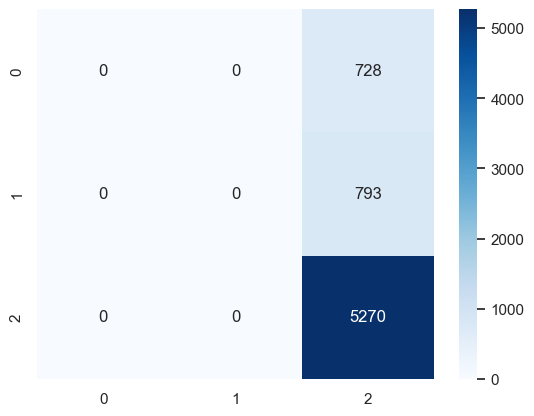

In [44]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

dummy_clf = DummyClassifier(strategy="most_frequent").fit(X_trainds, y_train)

print("Accuracy Score",accuracy_score(y_test, dummy_clf.predict(X_testds)))
print("-"*60)
print("Balanced Accuracy Score",balanced_accuracy_score(y_test, dummy_clf.predict(X_testds)))

cm = confusion_matrix(y_test,dummy_clf.predict(X_testds))
sns.heatmap(cm,cmap='Blues',annot=True,fmt='d')
plt.show()

As we can see in the dummy classifier, we can not rely on the accuracy score as we are working on the imbalanced dataset. We must combine several evaluation criteria.


#### Classification Reports

We are working on the imbalanced dataset and the Classification reports can help us determine which model is better than the others.

In [45]:
random_state = 42
classifiers = [DecisionTreeClassifier(random_state = random_state,class_weight = "balanced"),
             RandomForestClassifier(random_state = random_state),
             KNeighborsClassifier(),
             MultinomialNB()]

trained_classifier = []
acc_score_results = []
f1_score_results = []
roc_auc_score_results = []
elapsed_time = []

for model in classifiers:
    st = time.time()
    classifier = model.fit(X_trainds,y_train)
    y_pred = classifier.predict(X_testds)
    et = time.time()

    trained_classifier.append(classifier)
    acc_score_results.append(balanced_accuracy_score(y_test,y_pred))
    f1_score_results.append(f1_score(y_test,y_pred,average = 'weighted'))
    roc_auc_score_results.append(roc_auc_score(y_test,classifier.predict_proba(X_testds),multi_class='ovr')) 
    elapsed_time.append(float(et-st))
    

In [46]:
results_df = pd.DataFrame(data = {"trained_classifier":trained_classifier,
                                  "acc_score_results":acc_score_results,
                                  "f1_score_results":f1_score_results,
                                  "roc_auc_score_results":roc_auc_score_results,
                                  "elapsed_time":elapsed_time})

In [47]:
results_df

,trained_classifier,acc_score_results,f1_score_results,roc_auc_score_results,elapsed_time
0,DecisionTreeClassifier(class_weight='balanced'...,0.474272,0.706182,0.626610,8.740118
1,"(DecisionTreeClassifier(max_features='sqrt', r...",0.403138,0.727470,0.856098,23.949360
2,KNeighborsClassifier(),0.386637,0.714287,0.647729,9.087263
3,MultinomialNB(),0.612761,0.808482,0.880436,1.134491


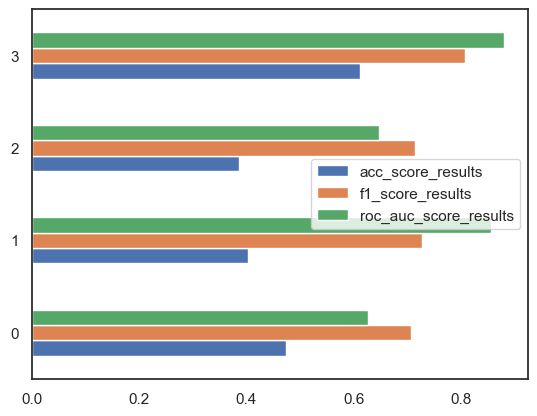

In [48]:
results_df[["acc_score_results","f1_score_results","roc_auc_score_results"]].plot.barh()
plt.show()

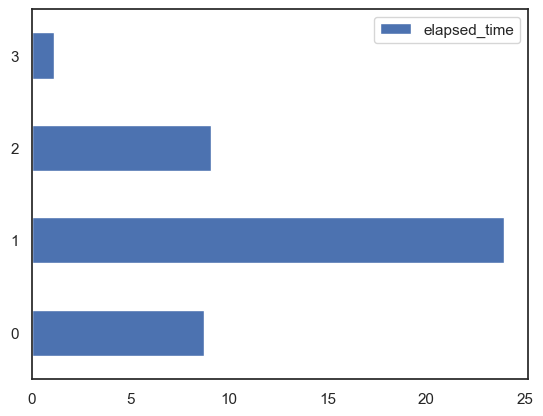

In [49]:
results_df.plot.barh(y = "elapsed_time")
plt.show()

BOW Classification Reports

In [51]:
for i in range(len(results_df)):
    y_pred = results_df.trained_classifier[i].predict(X_testds)
    print("\n",str(results_df.trained_classifier[i]))
    print(classification_report(y_test,y_pred))
    print("-"*90,"\n")


 DecisionTreeClassifier(class_weight='balanced', random_state=42)
              precision    recall  f1-score   support

          -1       0.29      0.34      0.31       728
           0       0.21      0.29      0.24       793
           1       0.87      0.80      0.83      5270

    accuracy                           0.69      6791
   macro avg       0.45      0.47      0.46      6791
weighted avg       0.73      0.69      0.71      6791

------------------------------------------------------------------------------------------ 


 RandomForestClassifier(random_state=42)
              precision    recall  f1-score   support

          -1       0.64      0.18      0.28       728
           0       0.49      0.04      0.07       793
           1       0.80      0.99      0.89      5270

    accuracy                           0.80      6791
   macro avg       0.65      0.40      0.41      6791
weighted avg       0.75      0.80      0.73      6791

------------------------------------

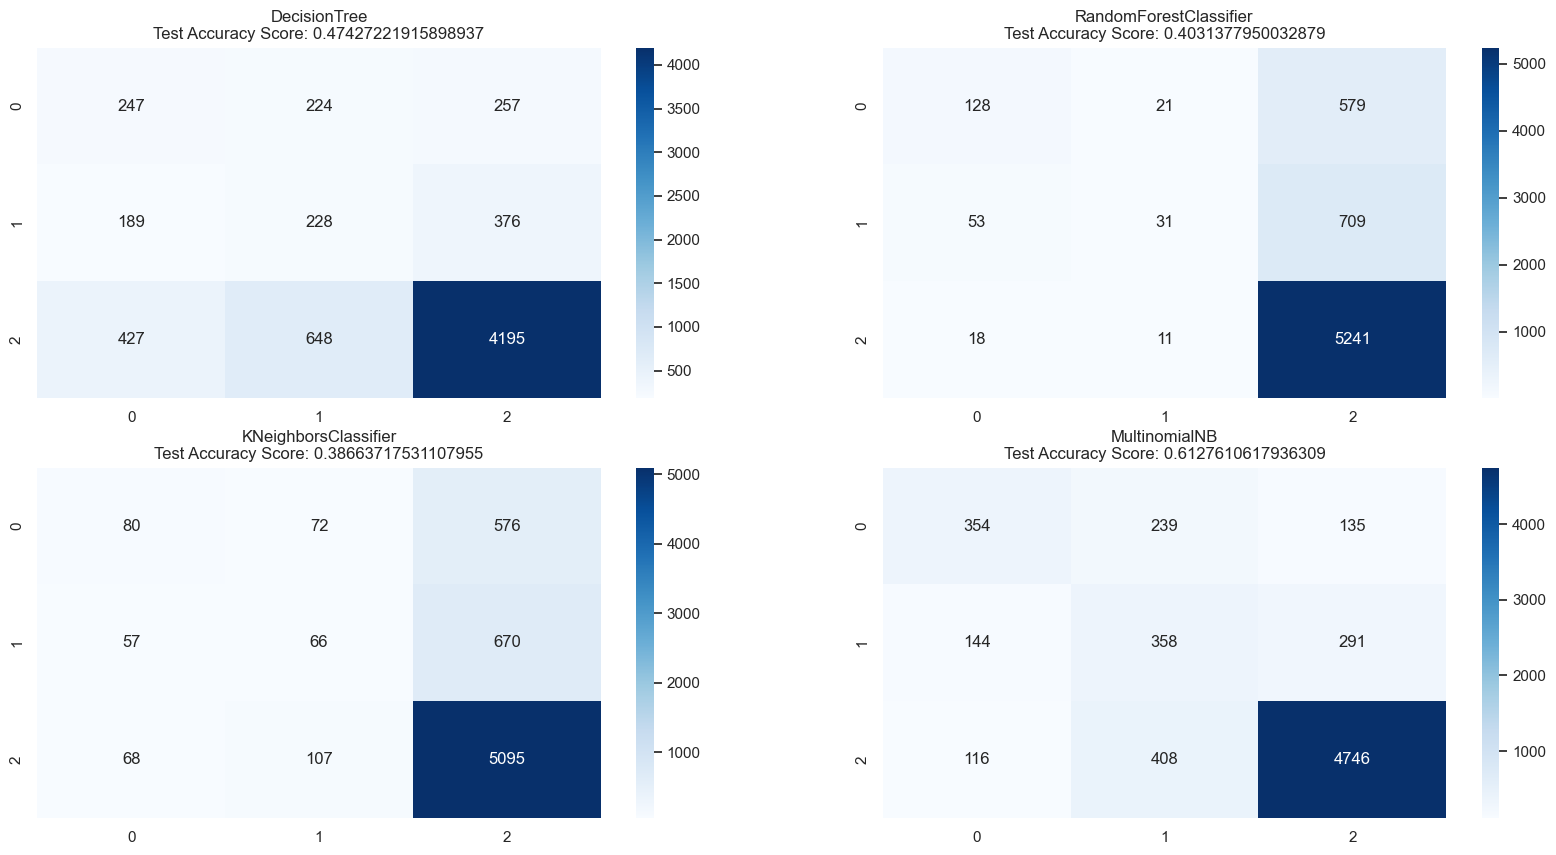

In [52]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(20,10))


cm_DecisionTree = confusion_matrix(y_test,results_df.trained_classifier[0].predict(X_testds))
cm_RandomForestClassifier = confusion_matrix(y_test,results_df.trained_classifier[1].predict(X_testds))
cm_KNeighborsClassifier = confusion_matrix(y_test,results_df.trained_classifier[2].predict(X_testds))
cm_MultinomialNB = confusion_matrix(y_test,results_df.trained_classifier[3].predict(X_testds))

sns.heatmap(cm_DecisionTree,cmap='Blues',annot=True,fmt='d',ax = ax1)
ax1.set_title("DecisionTree\nTest Accuracy Score: "+str(results_df.acc_score_results[0])  )
sns.heatmap(cm_RandomForestClassifier,cmap='Blues',annot=True,fmt='d',ax = ax2)
ax2.set_title("RandomForestClassifier\nTest Accuracy Score: "+str(results_df.acc_score_results[1]) )

sns.heatmap(cm_KNeighborsClassifier,cmap='Blues',annot=True,fmt='d',ax = ax3)
ax3.set_title("KNeighborsClassifier\nTest Accuracy Score: "+str(results_df.acc_score_results[2]) )

sns.heatmap(cm_MultinomialNB,cmap='Blues',annot=True,fmt='d',ax = ax4)
ax4.set_title("MultinomialNB\nTest Accuracy Score: "+str(results_df.acc_score_results[3]))

plt.show()

TF-IDF Vectorizer

In [ ]:
vectorizer = TfidfVectorizer()
X_trainds_tfidf = vectorizer.fit_transform(X_train).toarray()
X_testds_tfidf = vectorizer.transform(X_test).toarray()

In [ ]:
X_trainds_tfidf.shape

(15843, 7860)

In [ ]:
random_state = 42
classifiers = {  DecisionTreeClassifier(random_state = random_state,class_weight = "balanced"),
                 RandomForestClassifier(random_state = random_state),
                 KNeighborsClassifier(),
                 MultinomialNB()}

tf_idf_trained_classifier = []
tf_idf_acc_score_results = []
tf_idf_f1_score_results = []
tf_idf_roc_auc_score_results = []
tf_idf_elapsed_time = []

for model in classifiers:
    st = time.time()
    classifier = model.fit(X_trainds_tfidf,y_train)
    y_pred = classifier.predict(X_testds_tfidf)
    et = time.time()
    
    tf_idf_trained_classifier.append(classifier)
    tf_idf_acc_score_results.append(balanced_accuracy_score(y_test,y_pred))
    tf_idf_f1_score_results.append(f1_score(y_test,y_pred,average = 'weighted'))
    tf_idf_roc_auc_score_results.append(roc_auc_score(y_test,classifier.predict_proba(X_testds_tfidf),multi_class='ovr')) #One-vs-rest
    tf_idf_elapsed_time.append(float(et-st))

In [ ]:
tf_idf_results_df = pd.DataFrame(data = {"tf_idf_trained_classifier":tf_idf_trained_classifier,
                                          "tf_idf_acc_score_results":tf_idf_acc_score_results,
                                          "tf_idf_f1_score_results":tf_idf_f1_score_results,
                                          "tf_idf_roc_auc_score_results":tf_idf_roc_auc_score_results,
                                          "tf_idf_elapsed_time":tf_idf_elapsed_time
                                            })

In [ ]:
tf_idf_results_df

,tf_idf_trained_classifier,tf_idf_acc_score_results,tf_idf_f1_score_results,tf_idf_roc_auc_score_results,tf_idf_elapsed_time
0,DecisionTreeClassifier(class_weight='balanced'...,0.478172,0.702651,0.624213,36.549759
1,MultinomialNB(),0.337454,0.681506,0.855122,0.482586
2,"(DecisionTreeClassifier(max_features='sqrt', r...",0.372612,0.707626,0.864689,58.699287
3,KNeighborsClassifier(),0.448843,0.747733,0.725334,11.493990


<Axes: >

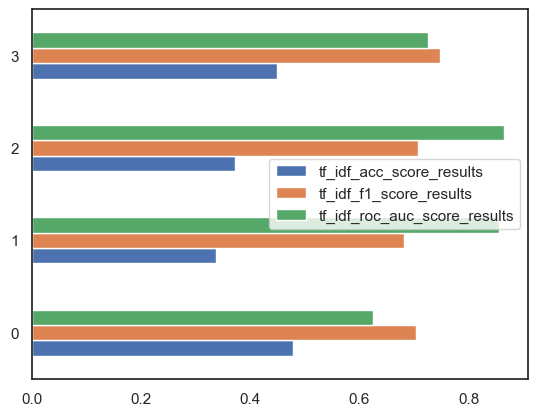

In [ ]:
tf_idf_results_df[["tf_idf_acc_score_results","tf_idf_f1_score_results","tf_idf_roc_auc_score_results"]].plot.barh()

<Axes: >

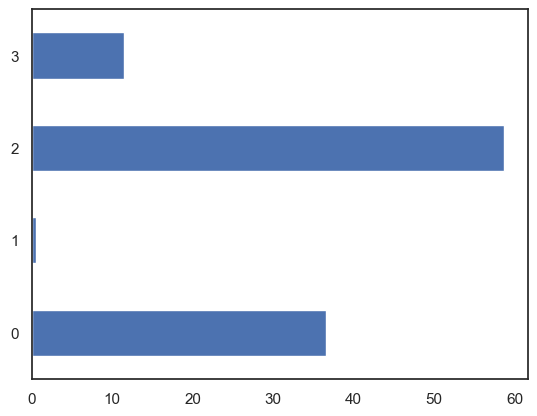

In [ ]:
tf_idf_results_df.tf_idf_elapsed_time.plot.barh()

TF-IDF Classification Reports

In [ ]:
for i in range(len(tf_idf_results_df)):
    y_pred = tf_idf_results_df.tf_idf_trained_classifier[i].predict(X_testds_tfidf)
    print("\n",str(tf_idf_results_df.tf_idf_trained_classifier[i]))
    print(classification_report(y_test,y_pred))
    print("-"*90,"\n")


 DecisionTreeClassifier(class_weight='balanced', random_state=42)
              precision    recall  f1-score   support

          -1       0.30      0.36      0.33       728
           0       0.21      0.28      0.24       793
           1       0.86      0.79      0.82      5270

    accuracy                           0.69      6791
   macro avg       0.46      0.48      0.46      6791
weighted avg       0.72      0.69      0.70      6791

------------------------------------------------------------------------------------------ 


 MultinomialNB()
              precision    recall  f1-score   support

          -1       0.82      0.01      0.02       728
           0       0.00      0.00      0.00       793
           1       0.78      1.00      0.87      5270

    accuracy                           0.78      6791
   macro avg       0.53      0.34      0.30      6791
weighted avg       0.69      0.78      0.68      6791

------------------------------------------------------------

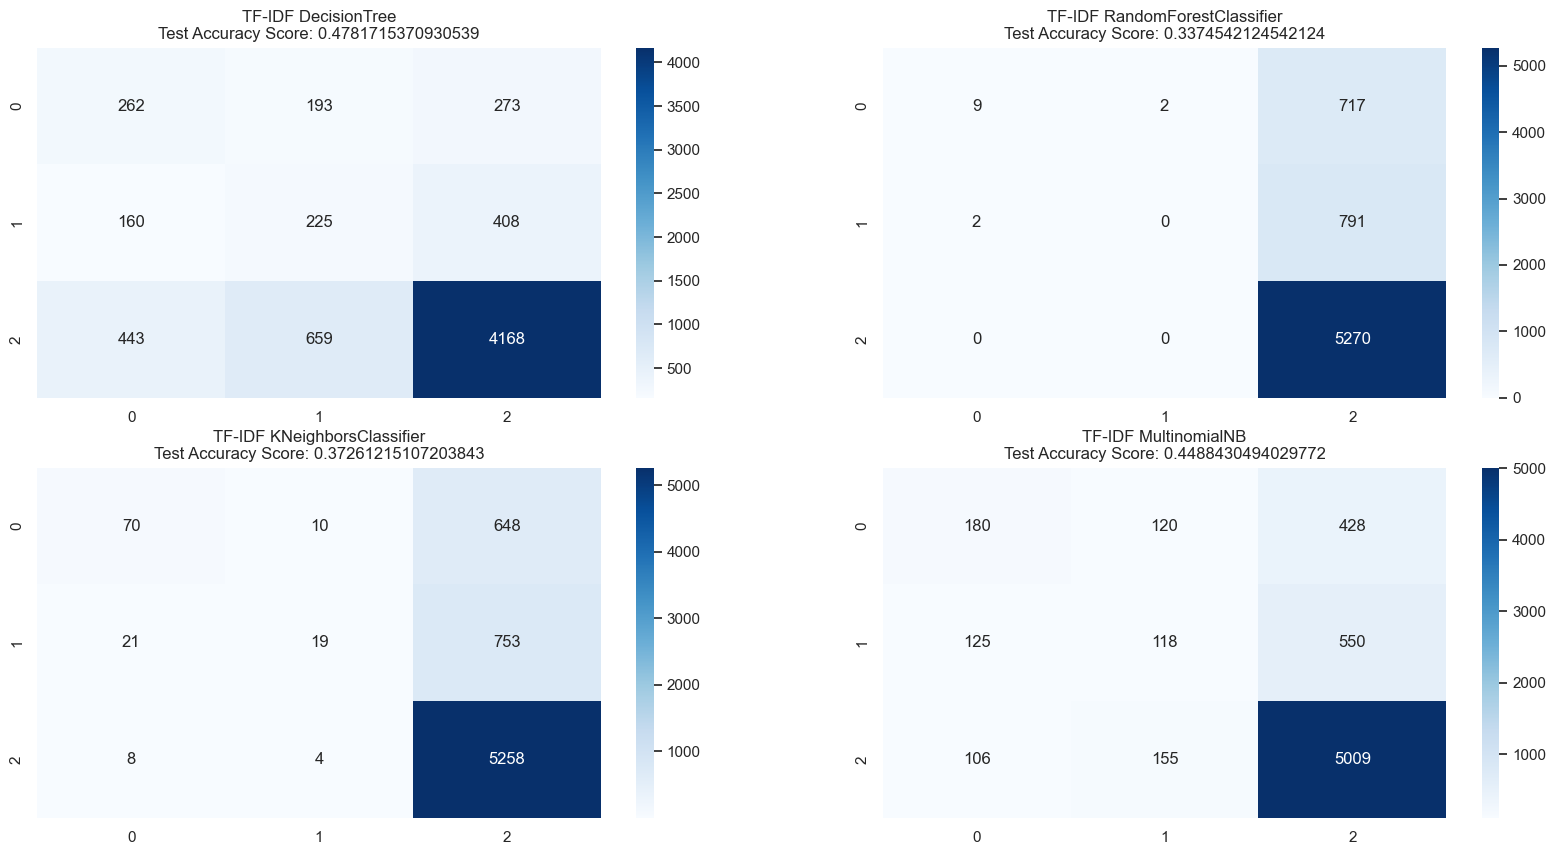

In [ ]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(20,10))


cm_DecisionTree = confusion_matrix(y_test,tf_idf_results_df.tf_idf_trained_classifier[0].predict(X_testds_tfidf))
cm_RandomForestClassifier = confusion_matrix(y_test,tf_idf_results_df.tf_idf_trained_classifier[1].predict(X_testds_tfidf))
cm_KNeighborsClassifier = confusion_matrix(y_test,tf_idf_results_df.tf_idf_trained_classifier[2].predict(X_testds_tfidf))
cm_MultinomialNB = confusion_matrix(y_test,tf_idf_results_df.tf_idf_trained_classifier[3].predict(X_testds_tfidf))

sns.heatmap(cm_DecisionTree,cmap='Blues',annot=True,fmt='d',ax = ax1)
ax1.set_title("TF-IDF DecisionTree\nTest Accuracy Score: "+str(tf_idf_results_df.tf_idf_acc_score_results[0])  )
sns.heatmap(cm_RandomForestClassifier,cmap='Blues',annot=True,fmt='d',ax = ax2)
ax2.set_title("TF-IDF RandomForestClassifier\nTest Accuracy Score: "+str(tf_idf_results_df.tf_idf_acc_score_results[1]) )

sns.heatmap(cm_KNeighborsClassifier,cmap='Blues',annot=True,fmt='d',ax = ax3)
ax3.set_title("TF-IDF KNeighborsClassifier\nTest Accuracy Score: "+str(tf_idf_results_df.tf_idf_acc_score_results[2]) )

sns.heatmap(cm_MultinomialNB,cmap='Blues',annot=True,fmt='d',ax = ax4)
ax4.set_title("TF-IDF MultinomialNB\nTest Accuracy Score: "+str(tf_idf_results_df.tf_idf_acc_score_results[3]))

plt.show()

PREDICTING PRODUCT IMPROVEMENT WORD USING NEGATIVE AND POSITIVE REVIEWS

In [80]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

df = pd.read_csv(r'C:\Users\parul\OneDrive\Desktop\TCD\Final Year project\Womens Clothing E-Commerce Reviews.csv')
df = df.fillna('NA')


X = df['Review Text']
y = df['Rating']

y = y.apply(lambda x: 1 if x >= 4 else 0)

vectorizer = CountVectorizer(stop_words='english')
X_vect = vectorizer.fit_transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=42)

clf = MultinomialNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

feature_names = vectorizer.get_feature_names_out()

# top features that are associated with negative sentiment
coef = clf.feature_log_prob_ 
top_features = sorted(zip(coef[0], feature_names))[:10]

print("Top features associated with negative sentiment:")
for coef, feature in top_features:
    print(feature)


Top features associated with negative sentiment:
000
02
03
03dd
0in
0petite
0r
0verall
0xs
1000


In [89]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
df = pd.read_csv(r'C:\Users\parul\OneDrive\Desktop\TCD\Final Year project\Womens Clothing E-Commerce Reviews.csv')
df = df.fillna('NA')
X = df['Review Text']
y = df['Rating']
y = y.apply(lambda x: 1 if x <= 3 else 0)
vectorizer = CountVectorizer(stop_words='english')
X_vect = vectorizer.fit_transform(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=42)
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
feature_names = vectorizer.get_feature_names_out()
coef = clf.feature_log_prob_
top_features = sorted(zip(coef[0], feature_names))[:10]
print("Top features associated with positive sentiment:")
for coef, feature in top_features:
    print(feature)


Top features associated with positive sentiment:
03dd
04
06
0dd
0verall
105lb
10l
10lbs
10x
112llbs


In [101]:
from textblob import TextBlob
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity
df = pd.read_csv(r'C:\Users\parul\OneDrive\Desktop\TCD\Final Year project\Womens Clothing E-Commerce Reviews.csv')
df = df.fillna('NA')
df['sentiment'] = df['Review Text'].apply(get_sentiment)
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x > 0 else 0)
X = df['Review Text']
y = df['sentiment']
vectorizer = CountVectorizer(stop_words='english')
X_vect = vectorizer.fit_transform(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=42)
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
feature_names = vectorizer.get_feature_names_out()
coef = clf.feature_log_prob_[0] - clf.feature_log_prob_[1]
top_features = sorted(zip(coef, feature_names))[:20]
print("Top features associated with positive sentiment:")
for coef, feature in top_features:
    print(feature)
coef = clf.feature_log_prob_[0] - clf.feature_log_prob_[1]
top_features = sorted(zip(-coef, feature_names))[:20]
print("Top features associated with negative sentiment:")
for coef, feature in top_features:
    print(feature)


Top features associated with positive sentiment:
glad
perfect
best
happy
justice
great
perfectly
excellent
seasons
cooler
amazing
cool
natural
beautifully
sweet
heels
rolled
easy
rich
warmer
Top features associated with negative sentiment:
na
bleach
blood
chrolox
depict
insulting
sends
104lbs
10mths
123lbssize
198
20lb
34ds
36e
3was
4inches
4l
6inches
6s
8s
